## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from tqdm import tqdm
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from pprint import pprint

from sklearn.decomposition import NMF

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pd.set_option('display.max_columns',100)
nlp = spacy.load('en_core_web_sm', exclude=['parser','ner'])

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('../input/complaints/complaints.json')# Write the path to your data file and load it 
  
# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
df.shape

(78313, 22)

In [5]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [8]:
#Assign new column names
columns = {}
for col in df.columns:
    columns[col] = col[1:].split('.')[-1]

df = df.rename(columns=columns, inplace=False)
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [9]:
#Assign nan in place of blanks in the complaints column
mask = df['complaint_what_happened']==''
df.loc[mask, 'complaint_what_happened'] = np.nan

In [10]:
#Remove all rows where complaints column is nan
rows_to_drop = df['complaint_what_happened'].isna()
df.drop(df.index[rows_to_drop], axis=0, inplace=True)
df = df.reset_index(drop=True)

In [11]:
df.loc[0,'complaint_what_happened']

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

In [12]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once we have removed all the blank complaints, we need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once we have done these cleaning operations we need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocess(complaint):
    # convert to lower case
    complaint = complaint.str.lower()
    
    # remove text in square brackets
    complaint = complaint.str.replace(r'\[.*?\]','',regex=True)
    
    #remove xx from text
    complaint = complaint.str.replace(r'x{2,}','',regex=True)
    
    #remove digits from text
    complaint = complaint.str.replace(r'\d+','',regex=True)
    
    return complaint

In [14]:
def tokenize_process(complaint):
    # remove specail charchters and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    complaint = complaint.apply(tokenizer.tokenize)

    complaint = complaint.apply(lambda row: ' '.join(row))
    nlp.Defaults.stop_words |= {"chase","jp", "morgan", "jpmorgan"}

    lemma_complaint = []
    for row in tqdm(complaint):
        lemm = []
        for token in nlp(row):
            if len(token.text)>1 and not token.is_stop and token.pos_!='PRON':
                lemm.append(token.lemma_)
        lemma_complaint.append(" ".join(lemm))
    
    return complaint, lemma_complaint

In [15]:
complaint = preprocess(df['complaint_what_happened'])
complaint, lemma_complaint = tokenize_process(complaint)

100%|██████████| 21072/21072 [05:26<00:00, 64.54it/s]


In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaints'] = complaint
df_clean['lemma_complaints'] = pd.Series(lemma_complaint)

## Exploratory data analysis to get familiar with the data.

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




#### Find the top 40 words by frequency among all the articles after processing the text.

In [17]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

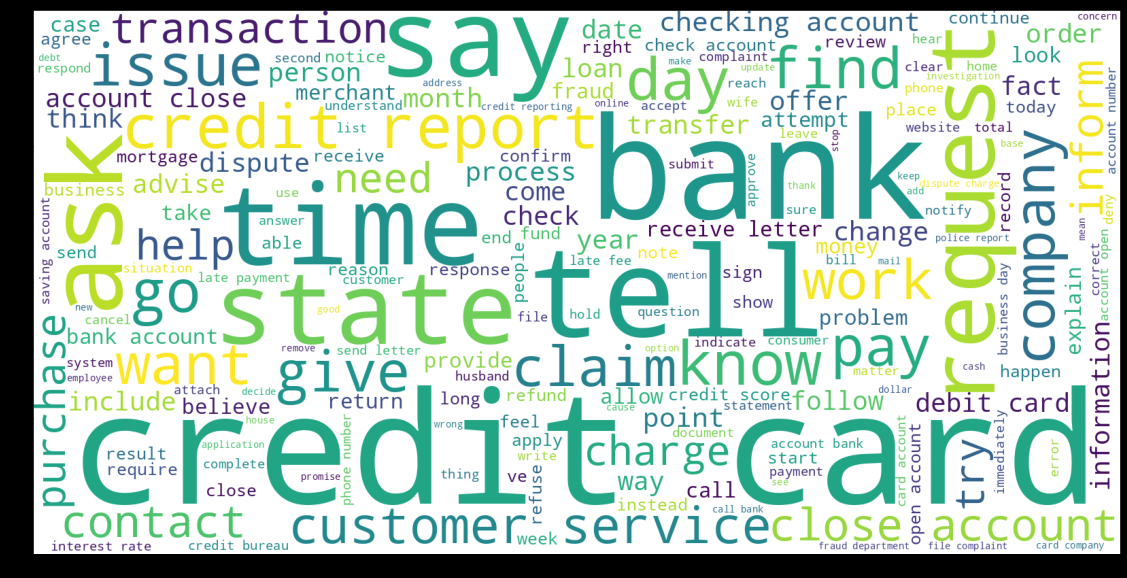

In [18]:
all_complaints = ' '.join(df_clean['lemma_complaints'].tolist())
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(all_complaints)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.show()

In [19]:
# TOp 40 words by frequency
filtered_words = all_complaints.split()
pd.Series(filtered_words).value_counts()[:40]

account        48847
credit         34318
card           30628
bank           28545
payment        21332
tell           19673
charge         18445
receive        17729
call           17277
pay            16746
time           16321
check          14837
say            14049
day            13312
send           13114
report         12382
money          11984
loan           11077
ask            11003
close          10162
letter          9724
state           9708
information     9684
go              9530
contact         9287
claim           9247
fee             9018
request         8963
transaction     8677
number          8665
month           8629
year            8471
dispute         8265
mortgage        8236
customer        8209
service         7900
provide         7889
balance         7859
phone           7746
company         7643
dtype: int64

In [20]:
c_vec = CountVectorizer(ngram_range = (1,1))
ngrams = c_vec.fit_transform(df_clean['lemma_complaints'])
count_values = ngrams.toarray().sum(axis=0)
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'uni_freq', 1:'unigram'})

In [21]:
df_ngram[:10]

,uni_freq,unigram
0,48847,account
1,34318,credit
2,30628,card
3,28545,bank
4,21332,payment
5,19673,tell
6,18445,charge
7,17729,receive
8,17277,call
9,16746,pay


In [22]:
c_vec = CountVectorizer(ngram_range = (2,2))
ngrams = c_vec.fit_transform(df_clean['lemma_complaints'])
count_values = ngrams.toarray().sum(axis=0)
vocab = c_vec.vocabulary_

In [23]:
df_ngram2 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'bi_freq', 1:'bigram'})

In [24]:
df_ngram2[:10]

,bi_freq,bigram
0,12889,credit card
1,3973,credit report
2,3079,customer service
3,3046,close account
4,2585,checking account
5,2178,account close
6,2073,debit card
7,2030,bank account
8,1889,receive letter
9,1809,check account


In [25]:
# Getting trigrams 
c_vec = CountVectorizer(ngram_range = (3,3))
ngrams = c_vec.fit_transform(df_clean['lemma_complaints'])
count_values = ngrams.toarray().sum(axis=0)
vocab = c_vec.vocabulary_
df_ngram3 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'tri_freq', 1:'trigram'})

In [26]:
df_ngram3[:10]

,tri_freq,trigram
0,997,credit card account
1,969,credit card company
2,639,call customer service
3,466,charge credit card
4,445,inquiry credit report
5,432,file police report
6,396,pay credit card
7,380,apply credit card
8,376,credit reporting agency
9,359,social security number


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [27]:
#All masked texts has been removed
df_clean.shape

(21072, 2)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [28]:
#Write your code here to initialise the TfidfVectorizer 
# tfidf = TfidfVectorizer(max_df=0.8, min_df=0.2, ngram_range=(1,3))
tfidf = TfidfVectorizer(
    min_df=30,
    max_df=0.8,
    max_features=50,
    ngram_range=(1, 2)
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [29]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['lemma_complaints'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task we have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
We need to do take the trial & error approach to find the best num of topics for our NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good our final topics are.

In [30]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 
random_state =40
nmf_model = NMF(num_topics)#write your code here

In [31]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

50

In [32]:
#Print the Top15 words for each of the topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print("==================================================")
        
print_top_words(nmf_model, tfidf.get_feature_names(), n_top_words=10)

Topic #0: account, bank, check, money, close, deposit, fund, tell, open, day
Topic #1: credit, card, credit card, report, account, company, information, close, year, open
Topic #2: loan, mortgage, year, request, letter, send, time, bank, receive, tell
Topic #3: charge, dispute, fee, card, transaction, call, claim, receive, tell, say
Topic #4: payment, pay, balance, month, fee, time, day, year, date, mortgage


In [33]:
components_df = pd.DataFrame(nmf_model.components_, columns=tfidf.get_feature_names())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
account    5.236011
bank       3.063302
check      2.415170
money      1.811314
close      1.498644
deposit    1.491815
fund       1.382358
tell       1.193658
open       1.146711
day        0.892847
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
credit         4.095955
card           3.386938
credit card    2.178055
report         1.762119
account        0.523097
company        0.459967
information    0.387591
close          0.374975
year           0.361621
open           0.323928
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
loan        3.768912
mortgage    2.475134
year        0.787841
request     0.739315
letter      0.727786
send        0.719464
time        0.696105
bank        0.665634
receive     0.619348
tell        0.580143
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
charge         3.450121
dispute        1.661229
fee            1.114127


In [34]:
nmf_features = nmf_model.transform(dtm)

In [35]:
#Assign the best topic to each of the cmplaints in Topic Column
nmf_features = pd.DataFrame(nmf_features)
df_clean['Topic'] = nmf_features.apply(lambda row: row.idxmax(), axis=1)

In [36]:
df_clean.head()

,complaints,lemma_complaints,Topic
0,good morning my name is and i appreciate it if...,good morning appreciate help stop bank cardmem...,0
1,i upgraded my card in and was told by the agen...,upgrade card tell agent upgrade anniversary da...,1
2,chase card was reported on however fraudulent ...,card report fraudulent application submit iden...,1
3,on while trying to book a ticket i came across...,try book ticket come offer apply ticket apply ...,1
4,my grand son give me check for i deposit it in...,grand son check deposit account fund clear ban...,0


In [37]:
#Print the first 5 Complaint for each of the Topics
df_clean2 = df_clean.groupby('Topic').head(5)
df_clean2

,complaints,lemma_complaints,Topic
0,good morning my name is and i appreciate it if...,good morning appreciate help stop bank cardmem...,0
1,i upgraded my card in and was told by the agen...,upgrade card tell agent upgrade anniversary da...,1
2,chase card was reported on however fraudulent ...,card report fraudulent application submit iden...,1
3,on while trying to book a ticket i came across...,try book ticket come offer apply ticket apply ...,1
4,my grand son give me check for i deposit it in...,grand son check deposit account fund clear ban...,0
5,can you please remove inquiry,remove inquiry,0
6,with out notice j p morgan chase restricted my...,notice restrict account debit card tuesday thu...,0
7,during the summer months i experience a declin...,summer month experience decline income employm...,4
8,on i made a payment to an online retailer usin...,payment online retailer quick pay website real...,3
9,i have a chase credit card which is incorrectl...,credit card incorrectly report datum credit re...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [38]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Bank Account services',1:'Credit card or prepaid card',2:'Theft/Dispute Reporting',3:'Mortgage/Loan',4:'Others'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [39]:
df_clean

,complaints,lemma_complaints,Topic
0,good morning my name is and i appreciate it if...,good morning appreciate help stop bank cardmem...,Bank Account services
1,i upgraded my card in and was told by the agen...,upgrade card tell agent upgrade anniversary da...,Credit card or prepaid card
2,chase card was reported on however fraudulent ...,card report fraudulent application submit iden...,Credit card or prepaid card
3,on while trying to book a ticket i came across...,try book ticket come offer apply ticket apply ...,Credit card or prepaid card
4,my grand son give me check for i deposit it in...,grand son check deposit account fund clear ban...,Bank Account services
...,...,...,...
21067,after being a chase card customer for well ove...,card customer decade offer multiple solicitati...,Credit card or prepaid card
21068,on wednesday i called chas my visa credit card...,wednesday call cha visa credit card provider a...,Mortgage/Loan
21069,i am not familiar with pay and did not underst...,familiar pay understand great risk provide con...,Mortgage/Loan
21070,i have had flawless credit for yrs i ve had ch...,flawless credit yrs ve credit card freedom spe...,Others


## Supervised model to predict any new complaints to the relevant Topics.

We have now build the model to create the topics for each complaints.Now in the below section we will use them to classify any new complaints.

Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [40]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['lemma_complaints','Topic']]

In [41]:
training_data

,lemma_complaints,Topic
0,good morning appreciate help stop bank cardmem...,Bank Account services
1,upgrade card tell agent upgrade anniversary da...,Credit card or prepaid card
2,card report fraudulent application submit iden...,Credit card or prepaid card
3,try book ticket come offer apply ticket apply ...,Credit card or prepaid card
4,grand son check deposit account fund clear ban...,Bank Account services
...,...,...
21067,card customer decade offer multiple solicitati...,Credit card or prepaid card
21068,wednesday call cha visa credit card provider a...,Mortgage/Loan
21069,familiar pay understand great risk provide con...,Mortgage/Loan
21070,flawless credit yrs ve credit card freedom spe...,Others


#### Apply the supervised models on the training data created. 

In this process, we have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [42]:
#Write your code to get the Vector count
tfidf = TfidfVectorizer(
    min_df=30,
    max_df=0.8,
    max_features=50,
    ngram_range=(1, 2)
)
word_vec = tfidf.fit_transform(training_data['lemma_complaints'])
#Write your code here to transform the word vector to tf-idf

In [43]:
topic_labels = training_data['Topic'].apply(lambda row: [key for key,val in Topic_names.items() if row==val][0])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(word_vec, topic_labels, test_size=0.3, random_state=40)

We are trying 3 models on the train & test data:
* Logistic regression
* Decision Tree
* Random Forest

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [45]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report

lr =LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.9792787092692186
0.9792499643516394
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1644
           1       0.98      0.99      0.99      1565
           2       0.99      0.97      0.98       933
           3       0.97      0.98      0.98      1464
           4       0.99      0.95      0.97       716

    accuracy                           0.98      6322
   macro avg       0.98      0.98      0.98      6322
weighted avg       0.98      0.98      0.98      6322



In [46]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.8634925656437836
0.8634913647611102
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1644
           1       0.89      0.87      0.88      1565
           2       0.87      0.89      0.88       933
           3       0.84      0.84      0.84      1464
           4       0.83      0.83      0.83       716

    accuracy                           0.86      6322
   macro avg       0.86      0.86      0.86      6322
weighted avg       0.86      0.86      0.86      6322



In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.9321417273014869
0.9319855571818684
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1644
           1       0.93      0.95      0.94      1565
           2       0.95      0.94      0.94       933
           3       0.92      0.91      0.91      1464
           4       0.95      0.87      0.91       716

    accuracy                           0.93      6322
   macro avg       0.94      0.93      0.93      6322
weighted avg       0.93      0.93      0.93      6322



In [48]:
def predict_random():
    sample = df.sample()['complaint_what_happened']
    z = preprocess(sample)
    _, z = tokenize_process(z)
    X = tfidf.transform(z)
    y = lr.predict(X)[0]
    print(sample.values)
    print("\t"*10)
    print(f"Label predicted: {Topic_names[y]}")

In [49]:
predict_random()

100%|██████████| 1/1 [00:00<00:00, 58.85it/s]

['On XXXX XXXX 2016 two payment were made from my account # XXXX for {$60.00} # XXXX for {$100.00} I had a deposits that day that covered all the payment I made. I did some shopping. Leaving my balance at {$29.00}. On XXXX XXXX a payment went out for {$54.00} leaving me with a negative balance. Not a big deal seeing home I had XXXX direct deposit getting ready to go through. At XXXX I checked my balance it was over {$900.00} showing both my deposits and no over draft fees. The chase employees have always told me that as long as the deposit is in the account prior to XXXX there would be no over draft fees. At XXXX the account showed everything going through fine. The next day they hit me with XXXX overdraft fees totally {$100.00} dollars. XXXX of the items causing the overdrafts were items that has went through days prior at which time they went through the amount was deducted from my account at that time. And the balance in my account reflected those deductions days prior. After going 